## **APLICACIÓN A DATA REAL DE US**

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import get_connection_covid_tracking,get_df_sql

import pandas as pd
import numpy as np
import psycopg2
import pandas.io.sql as sqlio

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from utils import get_connection_covid_tracking,get_df_sql

import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/reisson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Variables

In [34]:
# Consideramos los conceptos que tomamos en el notebook de introducción
maxRt = 12
rangeRt = np.linspace(0, maxRt, maxRt*100+1)
GAMMA = 1/7

#Enfocaremos el análisis en los siguientes estados de USA debido a que tienen mayor completitud de información
FILTERED_REGION_CODES = [f"'NY'", 
                         f"'AZ'", 
                         f"'CA'", 
                         f"'ND'",
                         f"'IA'",
                         f"'NE'",
                         f"'OK'",
                         f"'WY'",
                         f"'SC'",
                         f"'AR'"]



# Colores
ABOVE = [1,0,0]
MIDDLE = [1,1,1]
BELOW = [0,0,0]
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

### Funciones

In [4]:
def prepare_cases(dfCases, cutoff=25):
    newCases = dfCases.diff()
    smoothed = newCases.rolling(7,win_type='gaussian',min_periods=1,center=True)\
                       .mean(std=2)\
                       .round()
    idxStart = np.searchsorted(smoothed, cutoff)
    smoothed = smoothed.iloc[idxStart:]
    original = newCases.loc[smoothed.index]
    return original, smoothed

In [5]:
def get_posteriors(sr, sigma=0.15):
    # (1) Empleando lo realizado en el primer notebook, asignamos los valores a lambda
    _lambda = sr[:-1].values * np.exp(GAMMA * (rangeRt[:, None] - 1))    
    # (2) Calculo de probabilidad por cada dia
    likelihoods = pd.DataFrame(data = sps.poisson.pmf(sr[1:].values, _lambda),
                               index = rangeRt,
                               columns = sr.index[1:])
    
    # (3) Matriz gausiana
    gaussianMatrix = sps.norm(loc=rangeRt,scale=sigma)\
                        .pdf(rangeRt[:, None]) 

    # (3a) Estandarización(suma = 1)
    gaussianMatrix /= gaussianMatrix.sum(axis=0)
    
    # (4) Calculo del previo inicial
    prior0 = np.ones_like(rangeRt)/len(rangeRt)
    prior0 /= prior0.sum()

    # Dataframe que almacenara los posteriores para cada dia
    # Insertar nuestro previo como la primera posterior.
    posteriors = pd.DataFrame(index=rangeRt,
                              columns=sr.index,
                              data={sr.index[0]: prior0})
    
    # Seguimiento de la suma del logaritmo de probabilidad para el cálculo de MLE.
    logLikelihood = 0.0

    # (5) Aplicamos la regla de Bayes iterativamente
    for previousDay, currentDay in zip(sr.index[:-1], sr.index[1:]):
        #(5a) Calculato del nuevo priori
        currentPrior = gaussianMatrix @ posteriors[previousDay]
        #(5b) Calculo del numerador de la regla de Bayes: P(k|R_t)*P(R_t)
        numerator = likelihoods[currentDay] * currentPrior
        #(5c) Calculo del denominador de la regla de Bayes P(k)
        denominator = np.sum(numerator)
        # Ejecutamos la regla de Bayes: (P(k|R_t)*P(R_t))/(P(k))
        posteriors[currentDay] = numerator/denominator
        # Acumulamos el resultado de probabilidades
        logLikelihood += np.log(denominator)
        
    return posteriors, logLikelihood

In [6]:
def highest_density_interval(pmf, p=.9, debug=False):
    # Recibe un dataframe y llamara de forma recursiva a las columnas
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matriz de total pmf para cada intervalo(low-high)
    total_p = cumsum - cumsum[:, None]
    
    # Indices con total_p>p
    lows, highs = (total_p > p).nonzero()
    
    # Retornando el rango mas pequeño
    best = (highs - lows).argmin()
    
    lowBest = pmf.index[lows[best]]
    highBest = pmf.index[highs[best]]
    
    return pd.Series([lowBest, highBest],
                     index=[f'low{p*100:.0f}',
                            f'high{p*100:.0f}'])

In [7]:
def plot_rt(result, ax, state_name):
    ax.set_title(f"{state_name}")
    
    cmap = ListedColormap(np.r_[
                                np.linspace(BELOW,MIDDLE,25),
                                np.linspace(MIDDLE,ABOVE,25)
                                ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('time_date')
    values = result['ML'].values
    
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Extrapolacion de intervalo creible con margen 1 dia
    lowFn = interp1d(date2num(index),
                     result['low90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highFn = interp1d(date2num(index),
                      result['high90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-04-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowFn(date2num(extended)),
                    highFn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-04-01'), 
                result.index.get_level_values('time_date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [30]:
def plot_standings(mr, figsize=None, title='Mas reciente $R_t$'):
    if not figsize:
        figsize = ((1.5)*len(mr)+.1,5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['low90', 'high90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    fig.set_facecolor('w')
    return fig, ax

------------------

### DATASET

**NOTA:** 
- Los informes de casos son muy erráticos. Para obtener la mejor vista posible de los datos "verdaderos", se ha aplicado un filtro gaussiano a la serie temporal.

In [9]:
joinFilter = (',').join(FILTERED_REGION_CODES)
sql = f"SELECT * FROM public.get_dataset WHERE state_name in ({joinFilter});"
conn = get_connection_covid_tracking()
dfDataset = get_df_sql(sql,conn)
dfDataset['time_date'] = pd.to_datetime(dfDataset['time_date'])
dfDataset = dfDataset.set_index(['state_name','time_date'])\
                     .squeeze().sort_index()

Análisis Inicial de la ciudad de Nueva York (NY)

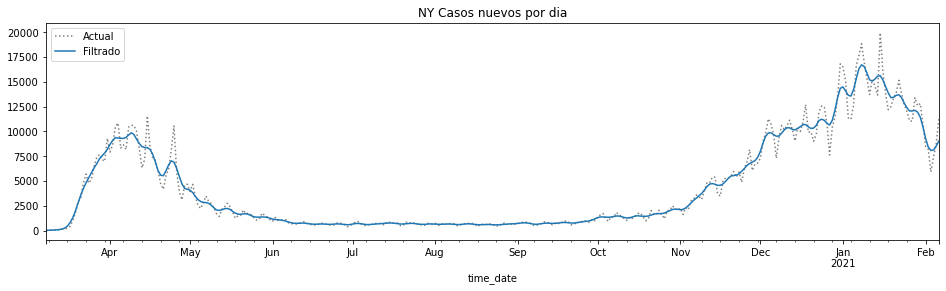

In [10]:
state_name = 'NY'
dfCasesNY = dfDataset.xs(state_name).rename(f"{state_name} cases")
original, smoothed = prepare_cases(dfCasesNY)
original.plot(title=f"{state_name} Casos nuevos por dia",
              c='k',
              linestyle=':',
              alpha=.5,
              label='Actual',
              legend=True,
              figsize=(16,4))
ax = smoothed.plot(label='Filtrado',
                   legend=True)
ax.get_figure().set_facecolor('w')

#### Elección de $\sigma$ : $P(R_t|R_{t-1})$

- Aplicamos ruido gaussiano a la distribución anterior con alguna desviación estándar $\sigma$.
A más elevado el valor de $\sigma$ habrá mucho más ruido y más elevado será la desviación que esperamos de $R_t$.
- Aplicar ruido sobre ruido de forma iterativa significa que habrá una decadencia natural de los posteriores distantes.
- Para calcular $\sigma$ utilizaremos el proceso de máxima probabilidad(ML).


ML nos permitirá elegir $\sigma$ que maximice la probabilidad :  $P(k|\sigma)$
- $\sigma$ es un valor fijo, por ello intentaremos maximizar $P(k)$ sobre las opciones de $\sigma$.

Dado $P(k)=P(k_0,k_1,\ldots,k_t)=P(k_0)P(k_1)\ldots P(k_t)$, definimos $P(k_t)$, el cual representa el denominador de la regla de Bayes:

$$P(R_t|k_t) = \frac{P(k_t|R_t)P(R_t)}{P(k_t)}$$

Para calcularlo, notamos que el numerador es en realidad solo la distribución conjunta de $k$ y $R$:

$$ P(k_t,R_t) =  P(k_t|R_t)P(R_t) $$

Podemos marginar la distribución sobre $R_t$ y obtenemos $P(k_t)$
  
Entonces, si sumamos la distribución del numerador sobre todos los valores de $R_t$, obtenemos $P(k_t)$. Y dado que estamos calculando eso de todos modos mientras calculamos el posterior, lo seguiremos por separado.Y dado que estamos calculando eso de todos modos mientras calculamos el posterior, lo seguiremos por separado.Dado que estamos buscando el valor de $\sigma$ que maximice $P(k)$ en general, en realidad queremos maximizar:

$$\prod_{t,i}{p(k_{ti})}$$
- $t$: tiempo 
- $i$: estado.

Al multiplicar muchas probabilidades pequeñas, es menos propenso a errores tomar el $\log$ de los valores y sumarlos.

Maximizamos la suma del $\log$  para cualquier elección de $\sigma$.

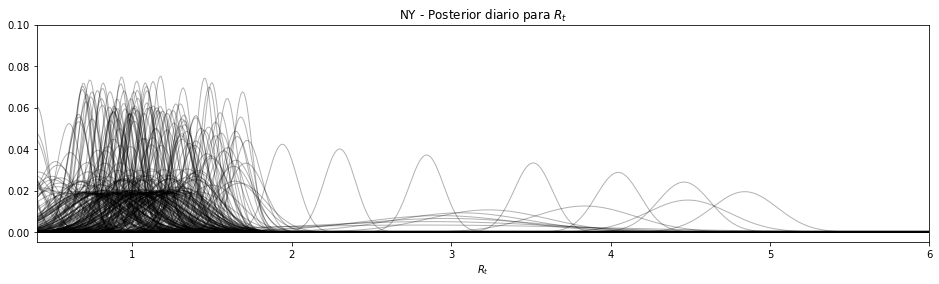

In [11]:
# EL valor de sigma en este caso es solo para el ejemplo
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

ax = posteriors.plot(title=f'{state_name} - Posterior diario para $R_t$',
                     legend=False, 
                     lw=1,
                     c='k',
                     alpha=.3,
                     xlim=(0.4,6),
                     figsize = (16,4))

ax.set_xlabel('$R_t$');

- Como podemos ver,los posteriores comienzan sin mucha confianza (amplios) y se vuelven progresivamente más seguros (más estrechos) sobre el verdadero valor de Rt

- Nuestros resultados incluyen incertidumbre, así veremos el valor más probable de Rt junto con su intervalo de densidad más alta.

In [12]:
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

result = pd.concat([most_likely, hdis], axis=1)
result.head()

,ML,low90,high90
time_date,,,
2020-03-08,0.00,0.00,10.81
2020-03-09,2.82,0.75,4.53
2020-03-10,2.87,1.51,4.10
2020-03-11,2.97,1.89,3.89
2020-03-12,2.93,2.06,3.71


Text(0.5, 1.0, '$R_t$ - NY')

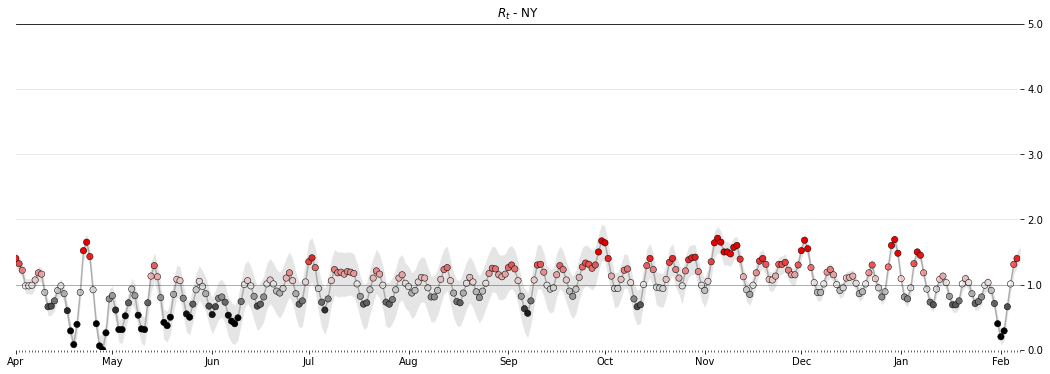

In [13]:
fig, ax = plt.subplots(figsize=(18,6))
plot_rt(result, ax, state_name)
ax.set_title(f'$R_t$ - {state_name}')

In [14]:
sigmas = np.linspace(1/20, 1, 20)
targets = dfDataset.index.get_level_values('state_name')
statesToProcess = dfDataset

## Eligiendo $\sigma$
- Evaluamndo cada estado con cualquier $\sigma$, elegimos la $\sigma$ óptima.
- Elegimos $\sigma$ que maximiza $P(k)$ en cada estado.

In [15]:
results = {}
for state_name, cases in statesToProcess.groupby(level='state_name'):
    print(state_name)
    new, smoothed = prepare_cases(cases, cutoff=25)
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=10)
    result = {}
    # Almacena los posteriores para cada valor de sigma
    result['posteriors'] = []
    # Almacena los log de probabilidad de todo k para cada sigma
    result['log_likelihoods'] = []
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    # Almacena los resultados por estado(state_name)
    results[state_name] = result
clear_output(wait=True)
print('Done.')

Done.


- Sumamos cada valor de sigma en todos los estados y elegimos el máximo.

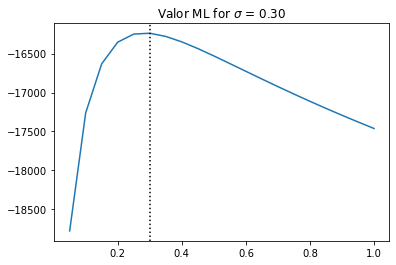

In [16]:
# Almacena el total de los log de probabilidades para cada sigma
totalLogLikelihoods = np.zeros_like(sigmas)

for state_name, result in results.items():
    totalLogLikelihoods += result['log_likelihoods']

# Indice del maximo valor en totalLogLikelihoods
maxLikelihoodIndex = totalLogLikelihoods.argmax()

# Valor de sigma que tiene log likelihood
sigma = sigmas[maxLikelihoodIndex]

fig, ax = plt.subplots()
ax.set_title(f"Valor ML for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, totalLogLikelihoods)
ax.axvline(sigma, color='k', linestyle=":")
fig.show()

- Como selecionamos el óptimo $\sigma$, tomamos el posterior precalculado correspondiente al óptimo $\sigma$ para cada estado.
- Calculamos 90% y 50% HDIs y MLs.

In [17]:
finalResults = None

for state_name, result in results.items():
    print(state_name)
    posteriors = result['posteriors'][maxLikelihoodIndex]
    hdi90 = highest_density_interval(posteriors, p=.9)
    hdi50 = highest_density_interval(posteriors, p=.5)
    mostLikely = posteriors.idxmax().rename('ML')
    result = pd.concat([mostLikely, hdi90, hdi50], axis=1)
    if finalResults is None:
        finalResults = result
    else:
        finalResults = pd.concat([finalResults, result])
clear_output(wait=True)
print('Done.')

Done.


- Vamos a visualizar el modelo aplicandoselo a los distintos estados que seleccionamos

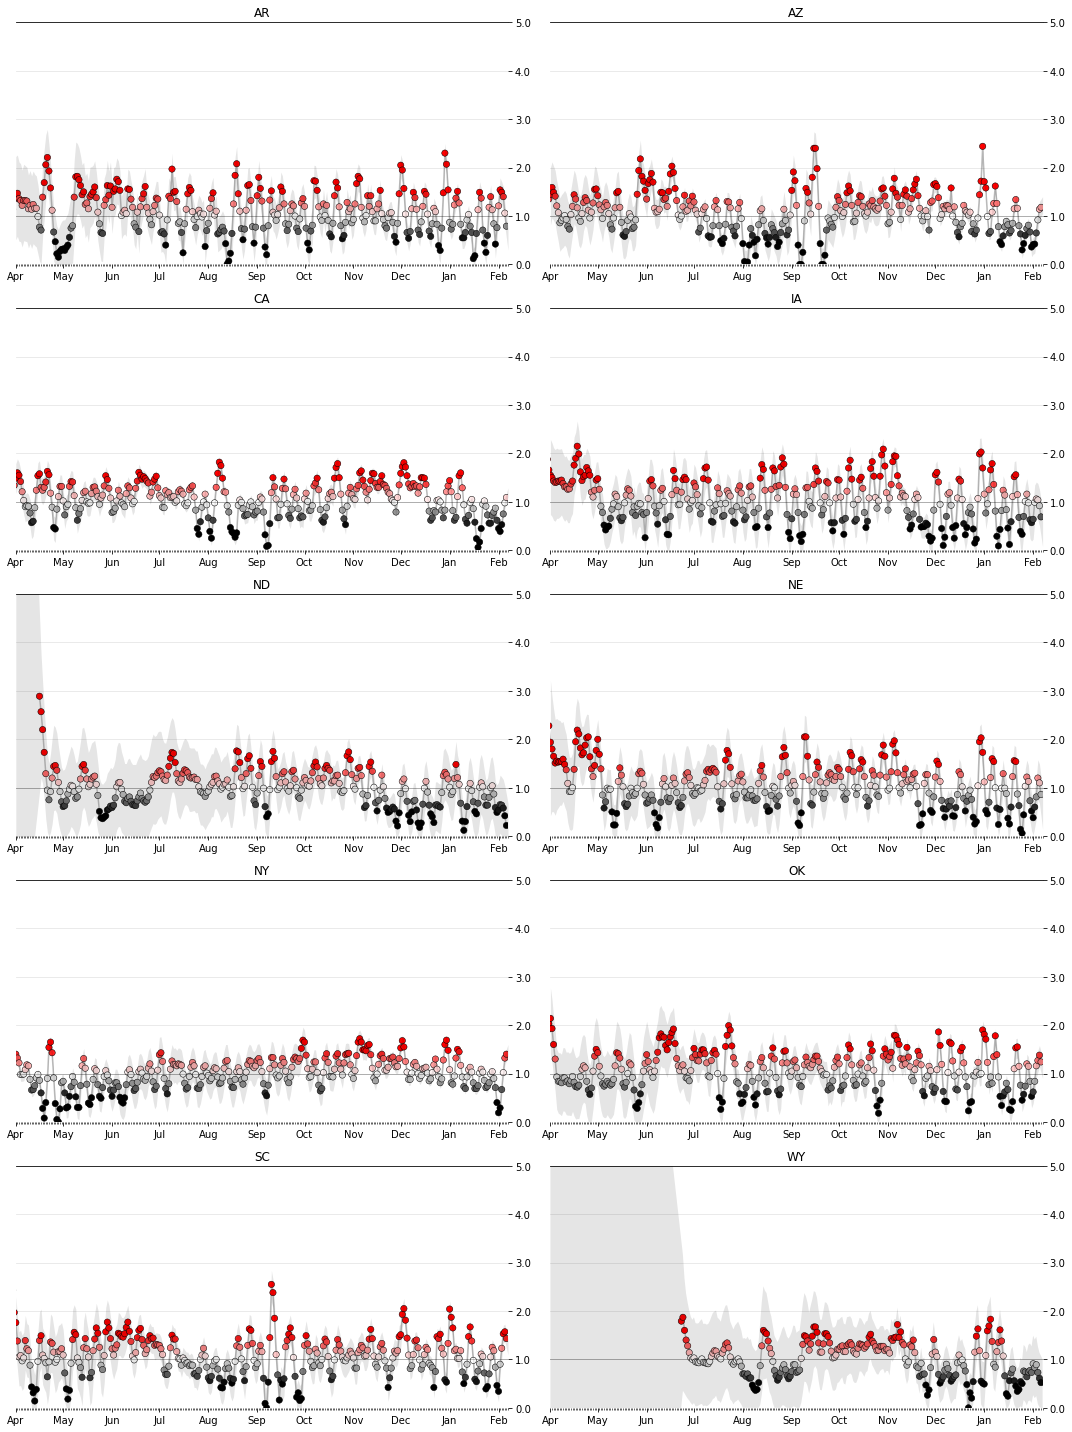

In [18]:
ncols = 2
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols, 
                         figsize=(15, nrows*4))

for i, (stateName, result) in enumerate(finalResults.groupby('state_name')):
    plot_rt(result.iloc[1:], axes.flat[i], stateName)

fig.tight_layout()
fig.set_facecolor('w')

In [19]:
finalResults = finalResults.groupby('state_name').apply(lambda x: x.iloc[1:].droplevel(0))
finalResults

ML  low90  high90  low50  high50
state_name time_date                                     
AR         2020-03-21  2.00   0.18    3.69   1.08    2.67
           2020-03-22  1.93   0.42    3.20   1.28    2.46
           2020-03-23  1.86   0.60    2.96   1.30    2.28
           2020-03-24  1.74   0.62    2.72   1.22    2.09
           2020-03-25  1.66   0.62    2.56   1.18    1.98
...                     ...    ...     ...    ...     ...
WY         2021-02-02  0.83   0.20    1.41   0.54    1.05
           2021-02-03  0.89   0.24    1.47   0.56    1.08
           2021-02-04  0.73   0.08    1.27   0.42    0.93
           2021-02-05  0.61   0.01    1.14   0.31    0.81
           2021-02-06  0.52   0.00    1.07   0.20    0.69

[3113 rows x 5 columns]

# Visualización de resultados

- Ordenamos los estados según el índice ML que presentan

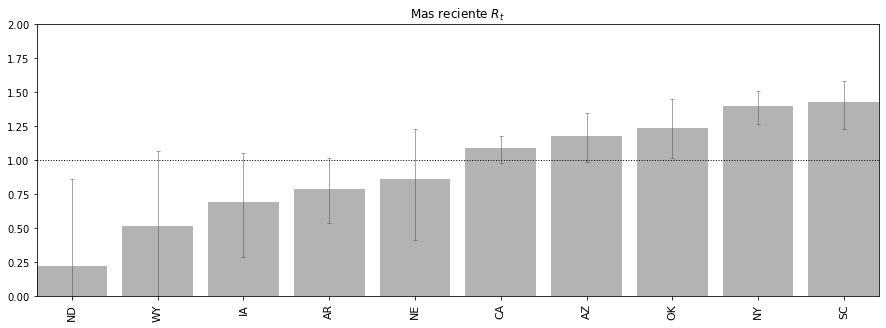

In [35]:
filtered = finalResults.index.get_level_values(0).isin(FILTERED_REGION_CODES)
mr = finalResults.loc[~filtered].groupby(level=0)[['ML', 'high90', 'low90']].last()
mr.sort_values('ML', inplace=True)
plot_standings(mr);

- Vemos los estados ordenados según el valor más alto de su HDI90

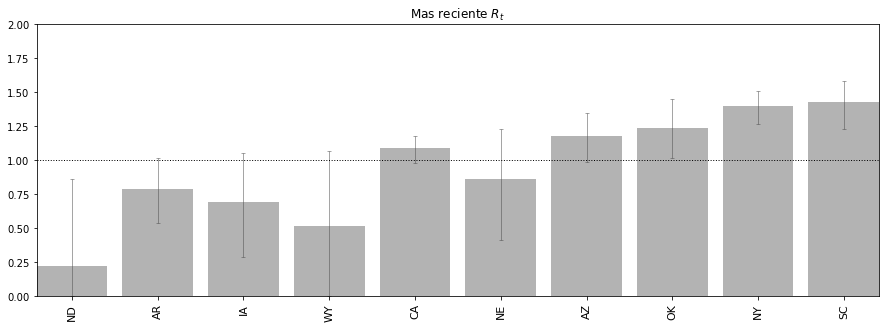

In [36]:
mr.sort_values('high90', inplace=True)
plot_standings(mr);

- Estados en los cuales, tomando en cuenta que el límite inferior del HDI 90 es mayor a 1, nos harían considerarlos como aquellos que la pandemia se les salió de control, debido a que una persona mínimamente está contagiando a mínimo uno por día

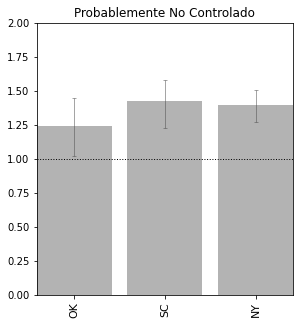

In [33]:
show = mr[mr.low90.ge(1.0)].sort_values('low90')
fig, ax = plot_standings(show, title='Probablemente No Controlado');
fig.show()